In [ ]:
# !pip install ultralytics

### Importations

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from ultralytics import YOLO
from timm.data import Mixup
from torchvision.transforms import RandomErasing
import gc
import torch.cuda
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
from torch.utils.data import DataLoader
from tqdm import tqdm
import timm
from PIL import Image
from tqdm.notebook import tqdm
from torchvision.transforms import ToTensor
from pathlib import Path
import pickle  

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [3]:
# Check GPU 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Check CUDA version 
if torch.cuda.is_available():
    print(f"CUDA Version: {torch.version.cuda}")
    print(f"GPU Device: {torch.cuda.get_device_name(0)}")
    
torch.manual_seed(42)
np.random.seed(42)

Using device: cuda
CUDA Version: 12.1
GPU Device: Tesla T4


### Init 

In [4]:
class_indexes_path = '/kaggle/input/m-2-bdia-dlia-project-2025/archive/dataset/class_indexes.csv'
class_indexes = pd.read_csv(class_indexes_path)
class_to_idx = dict(zip(class_indexes['category_cub'], class_indexes['idx']))
idx_to_class = {v: k for k, v in class_to_idx.items()}

train_dir = '/kaggle/input/m-2-bdia-dlia-project-2025/archive/dataset/train_images'
val_dir = '/kaggle/input/m-2-bdia-dlia-project-2025/archive/dataset/val_images'
test_dir = '//kaggle/input/m-2-bdia-dlia-project-2025/archive/dataset/test_images'


In [5]:
idx_to_class

{28: '185.Bohemian_Waxwing',
 10: '186.Cedar_Waxwing',
 5: '085.Horned_Lark',
 14: '188.Pileated_Woodpecker',
 6: '144.Common_Tern',
 2: '177.Prothonotary_Warbler',
 0: '179.Tennessee_Warbler',
 15: '099.Ovenbird',
 29: '167.Hooded_Warbler',
 20: '143.Caspian_Tern',
 3: '029.American_Crow',
 16: '073.Blue_Jay',
 21: '176.Prairie_Warbler',
 19: '183.Northern_Waterthrush',
 8: '039.Least_Flycatcher',
 7: '199.Winter_Wren',
 13: '192.Downy_Woodpecker',
 12: '182.Yellow_Warbler',
 22: '119.Field_Sparrow',
 26: '026.Bronzed_Cowbird',
 11: '025.Pelagic_Cormorant',
 9: '127.Savannah_Sparrow',
 1: '142.Black_Tern',
 25: '104.American_Pipit',
 24: '019.Gray_Catbird',
 23: '129.Song_Sparrow',
 27: '138.Tree_Swallow',
 4: '137.Cliff_Swallow',
 18: '195.Carolina_Wren',
 17: '135.Bank_Swallow'}

### Preprocessing : Using Yolo 

In [6]:
# Load a pretrained YOLOv5 model
yolo_model = YOLO('yolov5su.pt')
yolo_model.names

100%|██████████| 17.7M/17.7M [00:00<00:00, 140MB/s] 


{0: 'person',
 1: 'bicycle',
 2: 'car',
 3: 'motorcycle',
 4: 'airplane',
 5: 'bus',
 6: 'train',
 7: 'truck',
 8: 'boat',
 9: 'traffic light',
 10: 'fire hydrant',
 11: 'stop sign',
 12: 'parking meter',
 13: 'bench',
 14: 'bird',
 15: 'cat',
 16: 'dog',
 17: 'horse',
 18: 'sheep',
 19: 'cow',
 20: 'elephant',
 21: 'bear',
 22: 'zebra',
 23: 'giraffe',
 24: 'backpack',
 25: 'umbrella',
 26: 'handbag',
 27: 'tie',
 28: 'suitcase',
 29: 'frisbee',
 30: 'skis',
 31: 'snowboard',
 32: 'sports ball',
 33: 'kite',
 34: 'baseball bat',
 35: 'baseball glove',
 36: 'skateboard',
 37: 'surfboard',
 38: 'tennis racket',
 39: 'bottle',
 40: 'wine glass',
 41: 'cup',
 42: 'fork',
 43: 'knife',
 44: 'spoon',
 45: 'bowl',
 46: 'banana',
 47: 'apple',
 48: 'sandwich',
 49: 'orange',
 50: 'broccoli',
 51: 'carrot',
 52: 'hot dog',
 53: 'pizza',
 54: 'donut',
 55: 'cake',
 56: 'chair',
 57: 'couch',
 58: 'potted plant',
 59: 'bed',
 60: 'dining table',
 61: 'toilet',
 62: 'tv',
 63: 'laptop',
 64: 'mou

In [7]:
def detect_bird_region(image_path):
    results = yolo_model(image_path,verbose=False)
    bird_boxes = results[0].boxes[results[0].boxes.cls == 14]  # 14 is the class index for birds 
    if len(bird_boxes) > 0:
        return bird_boxes[0].xyxy[0].cpu().numpy()  # Return coordinates of the first detected bird
    return None


In [8]:
def preprocess_image(image_path):
    bird_box = detect_bird_region(image_path)
    if bird_box is not None:
        image = Image.open(image_path).convert('RGB')
        bird_image = image.crop(bird_box)
        return bird_image
    return Image.open(image_path).convert('RGB')

In [9]:
class BirdDataset(Dataset):
    def __init__(self, path, transforms=None, has_labels=True):
        super().__init__()
        self.path = path
        self.has_labels = has_labels
        self.transforms = transforms
        
        self.image_path = [] 
        self.labels = []      
        
        if has_labels:
            self.class_to_idx = {cls_name: idx for idx, cls_name in enumerate(sorted(f.name for f in Path(path).iterdir() if f.is_dir()))}
            
            for class_name in self.class_to_idx.keys():
                class_dir = Path(path) / class_name
                for img_path in class_dir.glob("*.jpg"): 
                    self.image_path.append(img_path)
                    self.labels.append(self.class_to_idx[class_name])

        else:
            self.image_path = list(Path(path).rglob("*.jpg"))

    def __len__(self):
        return len(self.image_path)

    def __getitem__(self, idx):
        image_path = self.image_path[idx]
        image = preprocess_image(image_path)

        with open(image_path, 'rb') as f:
            with Image.open(f) as img:
                image = img.convert('RGB')

        if self.transforms:
            image = self.transforms(image)

        if self.has_labels:
            label = self.labels[idx]
            return image, label

        # For test set, return only image and filename
        return image, image_path.name

In [10]:
train_transform = transforms.Compose([
    transforms.Resize((229, 229)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    ToTensor(),
    transforms.ConvertImageDtype(torch.float32),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    RandomErasing(p=0.5)  
])

mixup = Mixup(mixup_alpha=0.2, cutmix_alpha=0.2, prob=0.5, label_smoothing=0.1)

val_transform = transforms.Compose([
    transforms.Resize((229, 229)),
    ToTensor(), 
    transforms.ConvertImageDtype(torch.float32),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [11]:
batch_size = 128
# Initialize datasets
train_dataset = BirdDataset(path=train_dir, transforms=train_transform, has_labels=True)
val_dataset = BirdDataset(path=val_dir, transforms=val_transform, has_labels=True)

# Initialize data loaders
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)

print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")


Train dataset size: 1525
Validation dataset size: 270


In [12]:
num_classes = len(train_dataset.class_to_idx)
print(f"Number of classes: {num_classes}")

Number of classes: 30


### Model Creation and Testing


In this cell, I define a function `create_model` that initializes different pre-trained models based on the model name provided (`vgg19`, `inception_v3`, `efficientnet_b7`, or `convnext_large`). Each model is customized by adjusting the final classification layer to match the number of classes in the dataset.

**Note**: Unfortunately, I could not test all the models together and compare them due to CUDA memory limitations (Out of Memory error). I was able to test each model individually, but the system ran into memory issues when trying to run multiple models in parallel. As a result, I was unable to perform a full comparison of their performance in this notebook.


In [13]:
def create_model(model_name, num_classes, device):
    if model_name == 'vgg19':
        model = models.vgg19(weights=models.VGG19_Weights.DEFAULT)
        model.classifier[-1] = nn.Linear(model.classifier[-1].in_features, num_classes)
        
    elif model_name == 'inception_v3':
        model = models.inception_v3(weights=models.Inception_V3_Weights.DEFAULT)
        model.fc = nn.Linear(model.fc.in_features, num_classes)
        model.aux_logits = False
        
    elif model_name == 'efficientnet_b7':
        model = models.efficientnet_b7(weights=models.EfficientNet_B7_Weights.DEFAULT)
        model.classifier[-1] = nn.Linear(model.classifier[-1].in_features, num_classes)
        # Enable gradient checkpointing for EfficientNet
        for module in  model.modules():
            if hasattr(module, 'gradient_checkpointing'):
                module.gradient_checkpointing = True

    elif model_name == 'convnext_large':
        model = timm.create_model('convnext_large', pretrained=True, num_classes=num_classes)

                
    return model.to(device)

In [14]:
# Training and evaluation function
def train_and_evaluate_model(model_name, train_loader, val_loader, num_epochs=20, batch_size=32):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Clear GPU cache before starting
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        gc.collect()

    # Recreate data loaders with adjusted batch size
    train_loader = DataLoader(train_loader.dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_loader.dataset, batch_size=batch_size, shuffle=False)

    # Model init
    num_classes = len(train_loader.dataset.class_to_idx)
    model = create_model(model_name, num_classes, device)
    model = model.to(device)

    # Loss function
    criterion = nn.CrossEntropyLoss()

    # Optimizer and Scheduler
    optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
    scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)

    #  metrics
    train_losses = []
    val_accuracies = []

    epoch_pbar = tqdm(range(num_epochs), desc=f'Training {model_name}', position=0)

    for epoch in epoch_pbar:
        model.train()
        running_loss = 0.0

        batch_pbar = tqdm(enumerate(train_loader), 
                          total=len(train_loader), 
                          desc=f'Epoch {epoch+1}/{num_epochs}',
                          position=1, 
                          leave=False)

        for i, (inputs, labels) in batch_pbar:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad(set_to_none=True)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            # Update scheduler after each batch ; used to adjust the LR during training.
            scheduler.step(epoch + i / len(train_loader))

            running_loss += loss.item()

            batch_pbar.set_postfix({'loss': f'{loss.item():.4f}'})

            # Clear cache
            del outputs, loss
            if i % 2 == 0:
                torch.cuda.empty_cache()

        epoch_loss = running_loss / len(train_loader)
        train_losses.append(epoch_loss)

        # Validation phase
        model.eval()
        correct = 0
        total = 0

        val_pbar = tqdm(val_loader, desc='Validation', position=1, leave=False)

        with torch.no_grad():
            for inputs, labels in val_pbar:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                del outputs

        accuracy = 100 * correct / total
        val_accuracies.append(accuracy)

        epoch_pbar.set_postfix({
            'loss': f'{epoch_loss:.4f}',
            'accuracy': f'{accuracy:.2f}%'
        })

        # Clear cache after each epoch
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
            gc.collect()

    return model, train_losses, val_accuracies


In [15]:
# model_names = ['inception_v3']
model_names = ['convnext_large']

model_results = {}

for model_name in model_names:
    print(f"\nTraining {model_name}")
    try:
        model, train_losses, val_accuracies = train_and_evaluate_model(model_name, train_loader, val_loader,num_epochs=30)
        model_results[model_name] = {
            'model': model,
            'train_losses': train_losses,
            'val_accuracies': val_accuracies
        }
        
        with open(f'model_results{model_name}.pkl', 'wb') as f:
            pickle.dump(model_results, f)
        
        print("model_results saved successfully!")
    
    except RuntimeError as e:
        print(f"Error training {model_name}: {str(e)}")
        # Clear GPU memory before continuing to next model
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
            gc.collect()
        continue


Training convnext_large


model.safetensors:   0%|          | 0.00/791M [00:00<?, ?B/s]

Training convnext_large:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1/30:   0%|          | 0/48 [00:00<?, ?it/s]

Validation:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 2/30:   0%|          | 0/48 [00:00<?, ?it/s]

Validation:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 3/30:   0%|          | 0/48 [00:00<?, ?it/s]

Validation:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 4/30:   0%|          | 0/48 [00:00<?, ?it/s]

Validation:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 5/30:   0%|          | 0/48 [00:00<?, ?it/s]

Validation:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 6/30:   0%|          | 0/48 [00:00<?, ?it/s]

Validation:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 7/30:   0%|          | 0/48 [00:00<?, ?it/s]

Validation:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 8/30:   0%|          | 0/48 [00:00<?, ?it/s]

Validation:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 9/30:   0%|          | 0/48 [00:00<?, ?it/s]

Validation:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 10/30:   0%|          | 0/48 [00:00<?, ?it/s]

Validation:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 11/30:   0%|          | 0/48 [00:00<?, ?it/s]

Validation:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 12/30:   0%|          | 0/48 [00:00<?, ?it/s]

Validation:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 13/30:   0%|          | 0/48 [00:00<?, ?it/s]

Validation:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 14/30:   0%|          | 0/48 [00:00<?, ?it/s]

Validation:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 15/30:   0%|          | 0/48 [00:00<?, ?it/s]

Validation:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 16/30:   0%|          | 0/48 [00:00<?, ?it/s]

Validation:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 17/30:   0%|          | 0/48 [00:00<?, ?it/s]

Validation:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 18/30:   0%|          | 0/48 [00:00<?, ?it/s]

Validation:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 19/30:   0%|          | 0/48 [00:00<?, ?it/s]

Validation:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 20/30:   0%|          | 0/48 [00:00<?, ?it/s]

Validation:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 21/30:   0%|          | 0/48 [00:00<?, ?it/s]

Validation:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 22/30:   0%|          | 0/48 [00:00<?, ?it/s]

Validation:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 23/30:   0%|          | 0/48 [00:00<?, ?it/s]

Validation:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 24/30:   0%|          | 0/48 [00:00<?, ?it/s]

Validation:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 25/30:   0%|          | 0/48 [00:00<?, ?it/s]

Validation:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 26/30:   0%|          | 0/48 [00:00<?, ?it/s]

Validation:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 27/30:   0%|          | 0/48 [00:00<?, ?it/s]

Validation:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 28/30:   0%|          | 0/48 [00:00<?, ?it/s]

Validation:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 29/30:   0%|          | 0/48 [00:00<?, ?it/s]

Validation:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 30/30:   0%|          | 0/48 [00:00<?, ?it/s]

Validation:   0%|          | 0/9 [00:00<?, ?it/s]

model_results saved successfully!


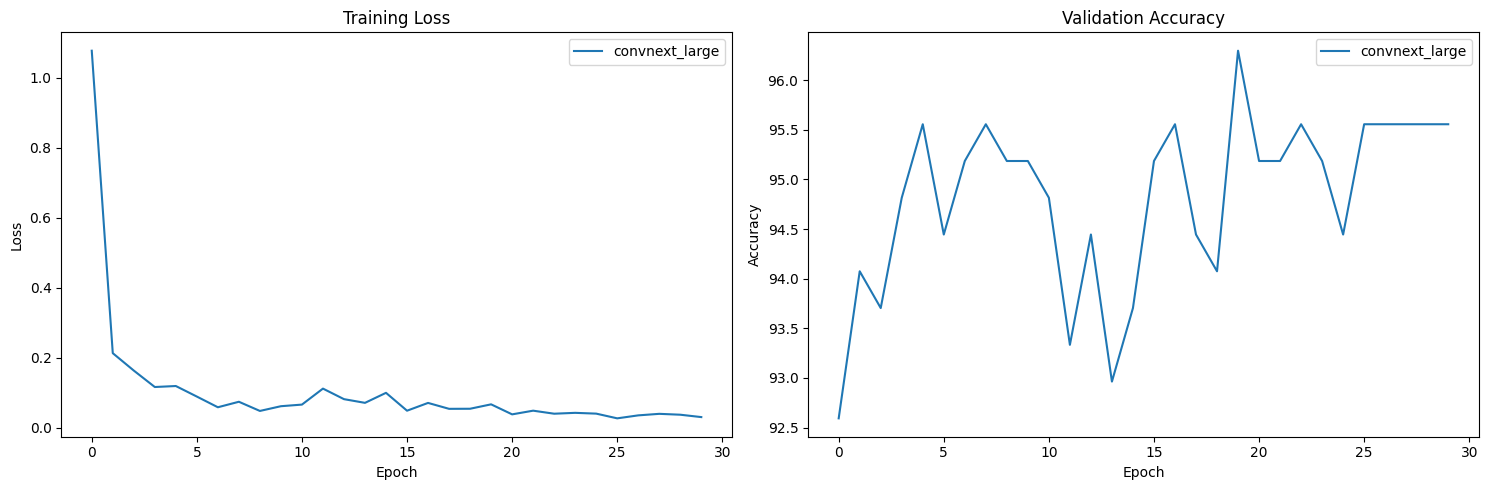

In [16]:
def plot_training_results(model_results):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    for model_name, results in model_results.items():
        ax1.plot(results['train_losses'], label=model_name)
        ax2.plot(results['val_accuracies'], label=model_name)
    
    ax1.set_title('Training Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    
    ax2.set_title('Validation Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    
    plt.tight_layout()
    plt.show()

plot_training_results(model_results)

In [17]:
def evaluate_model(model, data_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total
#ensemble_acc_vgg = evaluate_model(model_results["vgg19"]["model"], val_loader)
ensemble_acc_b4 = evaluate_model(model_results["convnext_large"]["model"], val_loader)

print(f"Validation Accuracy efficientnet_b3 : {ensemble_acc_b4:.4f}")

#print(f"Validation Accuracy vgg19 : {ensemble_acc_vgg:.4f}")

# The ouput is Validation Accuracy convnext_large : 0.9556 NOT efficientnet_b3 

Validation Accuracy efficientnet_b3 : 0.9556


### Predicition and submission

In [18]:
def predict(model, data_loader):
    model.eval()
    predictions = []
    with torch.no_grad():
        for inputs, _ in data_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            predictions.extend(preds.cpu().numpy())
    return predictions


In [19]:
best_model_name = max(model_results, key=lambda x: max(model_results[x]['val_accuracies']))
best_model = model_results[best_model_name]['model']
print(f"Best model: {best_model_name}")

Best model: convnext_large


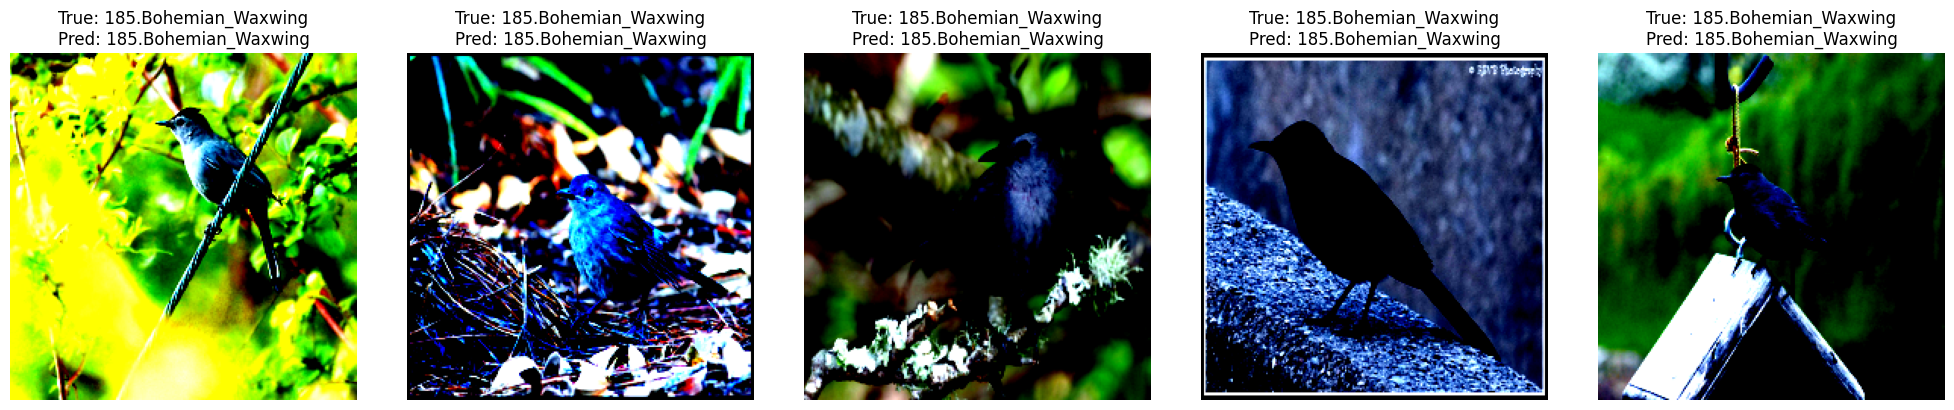

In [20]:
class_names = list(idx_to_class.values())
# Visualize sample predictions
def visualize_predictions(model, data_loader, num_samples=5):
    model.eval()
    images, labels = next(iter(data_loader))
    images, labels = images[:num_samples].to(device), labels[:num_samples].to(device)
    
    with torch.no_grad():
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
    
    fig, axes = plt.subplots(1, num_samples, figsize=(20, 4))
    for i, (image, label, pred) in enumerate(zip(images, labels, preds)):
        axes[i].imshow(image.cpu().permute(1, 2, 0))
        axes[i].set_title(f"True: {class_names[label]}\nPred: {class_names[pred]}")
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()

visualize_predictions(best_model, val_loader)


In [21]:
test_dataset = BirdDataset(path=test_dir, transforms=val_transform, has_labels=False)

test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)  

len(test_dataset)

620

In [22]:
test_predictions = predict(best_model, test_loader)

In [23]:
# Create submission file
submission_df = pd.DataFrame({
    'id': [f.split('.')[0] for f in os.listdir(test_dir) if f.endswith('.jpg')],
    'category':  test_predictions
})


##### Mapping to the right class indexes

In [24]:
bird_folders = {
    0: "019.Gray_Catbird",
    1: "025.Pelagic_Cormorant",
    2: "026.Bronzed_Cowbird",
    3: "029.American_Crow",
    4: "039.Least_Flycatcher",
    5: "073.Blue_Jay",
    6: "085.Horned_Lark",
    7: "099.Ovenbird",
    8: "104.American_Pipit",
    9: "119.Field_Sparrow",
    10: "127.Savannah_Sparrow",
    11: "129.Song_Sparrow",
    12: "135.Bank_Swallow",
    13: "137.Cliff_Swallow",
    14: "138.Tree_Swallow",
    15: "142.Black_Tern",
    16: "143.Caspian_Tern",
    17: "144.Common_Tern",
    18: "167.Hooded_Warbler",
    19: "176.Prairie_Warbler",
    20: "177.Prothonotary_Warbler",
    21: "179.Tennessee_Warbler",
    22: "182.Yellow_Warbler",
    23: "183.Northern_Waterthrush",
    24: "185.Bohemian_Waxwing",
    25: "186.Cedar_Waxwing",
    26: "188.Pileated_Woodpecker",
    27: "192.Downy_Woodpecker",
    28: "195.Carolina_Wren",
    29: "199.Winter_Wren"
}

bird_folders_reverse = {
    "185.Bohemian_Waxwing": 28,
    "186.Cedar_Waxwing": 10,
    "085.Horned_Lark": 5,
    "188.Pileated_Woodpecker": 14,
    "144.Common_Tern": 6,
    "177.Prothonotary_Warbler": 2,
    "179.Tennessee_Warbler": 0,
    "099.Ovenbird": 15,
    "167.Hooded_Warbler": 29,
    "143.Caspian_Tern": 20,
    "029.American_Crow": 3,
    "073.Blue_Jay": 16,
    "176.Prairie_Warbler": 21,
    "183.Northern_Waterthrush": 19,
    "039.Least_Flycatcher": 8,
    "199.Winter_Wren": 7,
    "192.Downy_Woodpecker": 13,
    "182.Yellow_Warbler": 12,
    "119.Field_Sparrow": 22,
    "026.Bronzed_Cowbird": 26,
    "025.Pelagic_Cormorant": 11,
    "127.Savannah_Sparrow": 9,
    "142.Black_Tern": 1,
    "104.American_Pipit": 25,
    "019.Gray_Catbird": 24,
    "129.Song_Sparrow": 23,
    "138.Tree_Swallow": 27,
    "137.Cliff_Swallow": 4,
    "195.Carolina_Wren": 18,
    "135.Bank_Swallow": 17
}


submission_df['category'] = submission_df['category'].map(bird_folders)

submission_df['category'] = submission_df['category'].map(bird_folders_reverse)

submission_df.to_csv("submissions_with_idx.csv", index=False)

print("Fichier modifié sauvegardé sous 'submissions_with_idx.csv'.")

Fichier modifié sauvegardé sous 'submissions_with_idx.csv'.


Thanks

## Acknowledgment

This work is based on the paper titled **"Bird Detection and Species Classification: Using YOLOv5 and Deep Transfer Learning Models"**, published in **IJACSA-International Journal of Advanced Computer Science and Applications, Vol. 14, No. 7, 2023** by the authors:

- Hoang-Tu Vo
- Nhon Nguyen Thien
- Kheo Chau Mui

Software Engineering Department, FPT University, Cantho city, Vietnam.
